In [98]:
## Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [99]:
## Constants
DPAST = 14;

In [100]:
## Process data
data = pd.read_csv('/Users/kevinkristensen/Desktop/CS760/CS760Python/finalprojectdata.csv')
counties = data[data.columns[0]]
n_counties = len(pd.unique(counties)) # total number of counties
n_days = len(counties[counties == counties[0]]) # total number of days per county
data_numeric = data[data.columns[2:]].values
n_cols = data_numeric.shape[1] # n_cols = 5
N_cols = n_cols*DPAST # number of columns in final design matrix
N_rows = (n_days-DPAST)*n_counties
print('N_cols = %d, N_rows = %d' % (N_cols, N_rows))

# partition data by county, then aggregate
X = np.empty([N_rows, N_cols])
y = np.empty(N_rows)
X_Dane = np.empty([n_days-DPAST, N_cols])
y_Dane = np.empty(n_days-DPAST)
for i in range(n_counties):
    temp_data = data_numeric[i*n_days:(i+1)*n_days]
    for j in range(DPAST, n_days):
        temp_subdata = temp_data[j-DPAST:j].T
        X[i*(n_days-DPAST)+j-DPAST] = temp_subdata.reshape((1, N_cols))
        y[i*(n_days-DPAST)+j-DPAST] = temp_data[j, n_cols-1] - temp_data[j-1, n_cols-1]
        if i == 1:
            X_Dane[j-DPAST] = X[i*(n_days-DPAST)+j-DPAST]
            y_Dane[j-DPAST] = y[i*(n_days-DPAST)+j-DPAST]
        
# X[i] = [X_1,...,X_4,X_5] where X_j.shape = (DPAST,), containing data from
# past DPAST days corresponding to column j in data, and y[i] is number of
# new infections on that day

N_cols = 70, N_rows = 6003


In [102]:
## Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

In [116]:
## Train linear regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

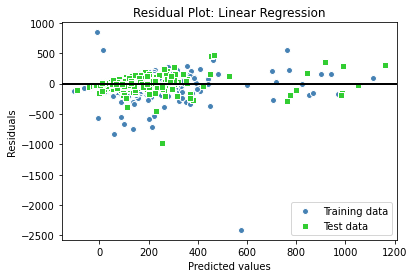

In [120]:
## Create residual plot, Dane county plot
plt.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='lower right')
plt.title('Residual Plot: Linear Regression')
l = min([y_train_pred.min(), y_test_pred.min()]) - 50
u = max([y_train_pred.max(), y_test_pred.max()]) + 50
plt.hlines(y=0, xmin=l, xmax=u, color='black', lw=2)
plt.xlim([l, u])
plt.savefig('RplotLR.pdf')
plt.show()

In [105]:
## Compute MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print('MSE train: %.2f, test: %.2f' % (
      mean_squared_error(y_train, y_train_pred),
      mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.4f, test: %.4f' % (
      r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

MSE train: 4112.75, test: 2482.04
R^2 train: 0.6150, test: 0.7537


MSE train: 4785.28, test: 2327.23
R^2 train: 0.5520, test: 0.7691


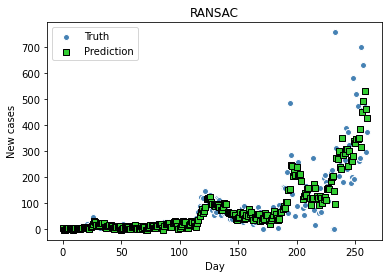

In [126]:
## Train RANSAC model
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=500,
                         loss='absolute_loss',
                         residual_threshold=50)
ransac.fit(X_train, y_train)
y_train_pred = ransac.predict(X_train)
y_test_pred = ransac.predict(X_test)

print('MSE train: %.2f, test: %.2f' % (
      mean_squared_error(y_train, y_train_pred),
      mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.4f, test: %.4f' % (
      r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

y_Dane_pred = ransac.predict(X_Dane)
days = np.arange(n_days-DPAST)
plt.scatter(days, y_Dane, c='steelblue', marker='o',
            edgecolor='white', label='Truth')
plt.scatter(days, y_Dane_pred, c='limegreen', marker='s',
            edgecolor='black', label='Prediction')
plt.xlabel('Day')
plt.ylabel('New cases')
plt.legend(loc='upper left')
plt.title('RANSAC')
plt.savefig('RANSACprofile.pdf')
plt.show()

In [107]:
## Train LASSO model, selecting hyperparameter by cross-validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(max_iter=50000) 
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print('MSE train: %.2f, MSE test: %.2f, alpha: %.2f' % (
      mean_squared_error(y_train, y_train_pred),
      mean_squared_error(y_test, y_test_pred),
      lasso.alpha_))
print('R^2 train: %.4f, test: %.4f' % (
      r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

MSE train: 4303.53, MSE test: 2296.65, alpha: 362.84
R^2 train: 0.5971, test: 0.7721


In [108]:
## Train Ridge model, selecting hyperparameter by cross-validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV() 
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

print('MSE train: %.2f, MSE test: %.2f, alpha: %.2f' % (
      mean_squared_error(y_train, y_train_pred),
      mean_squared_error(y_test, y_test_pred),
      ridge.alpha_)) 
print('R^2 train: %.4f, test: %.4f' % (
      r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

MSE train: 4112.75, MSE test: 2482.02, alpha: 10.00
R^2 train: 0.6150, test: 0.7537


MSE train: 4306.75, test: 2294.06
R^2 train: 0.5968, test: 0.7724


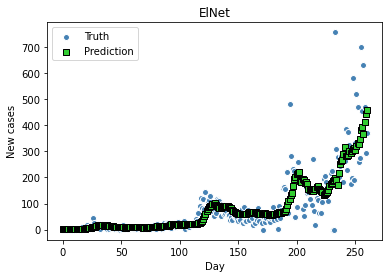

In [125]:
## Train Elastic Net model, selecting hyperparameter by cross-validation
from sklearn.linear_model import ElasticNetCV
ela = ElasticNetCV(max_iter=50000) 
ela.fit(X_train, y_train)
y_train_pred = ela.predict(X_train)
y_test_pred = ela.predict(X_test)

print('MSE train: %.2f, test: %.2f' % (
      mean_squared_error(y_train, y_train_pred),
      mean_squared_error(y_test, y_test_pred),))
print('R^2 train: %.4f, test: %.4f' % (
      r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

y_Dane_pred = ela.predict(X_Dane)
days = np.arange(n_days-DPAST)
plt.scatter(days, y_Dane, c='steelblue', marker='o',
            edgecolor='white', label='Truth')
plt.scatter(days, y_Dane_pred, c='limegreen', marker='s',
            edgecolor='black', label='Prediction')
plt.xlabel('Day')
plt.ylabel('New cases')
plt.legend(loc='upper left')
plt.title('ElNet')
plt.savefig('ElNetprofile.pdf')
plt.show()

In [110]:
## Train random forest model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.2f, test: %.2f' % (
      mean_squared_error(y_train, y_train_pred),
      mean_squared_error(y_test, y_test_pred),))
print('R^2 train: %.4f, test: %.4f' % (
      r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

MSE train: 616.42, test: 4764.58
R^2 train: 0.9423, test: 0.5273


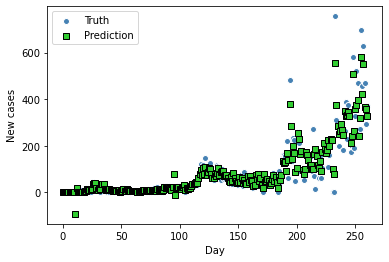

In [112]:
## Compare prediction vs. truth for Dane county
y_Dane_pred = forest.predict(X_Dane)
days = np.arange(n_days-DPAST)
plt.scatter(days, y_Dane, c='steelblue', marker='o',
            edgecolor='white', label='Truth')
plt.scatter(days, y_Dane_pred, c='limegreen', marker='s',
            edgecolor='black', label='Prediction')
plt.xlabel('Day')
plt.ylabel('New cases')
plt.legend(loc='upper left')
plt.show()

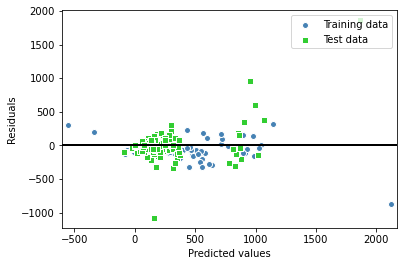

In [113]:
## Create residual plot
plt.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper right')
l = min([y_train_pred.min(), y_test_pred.min()]) - 50
u = max([y_train_pred.max(), y_test_pred.max()]) + 50
plt.hlines(y=0, xmin=l, xmax=u, color='black', lw=2)
plt.xlim([l, u])
plt.show()

MSE train: 223.42, test: 22006.39
R^2 train: 0.9791, test: -1.1835


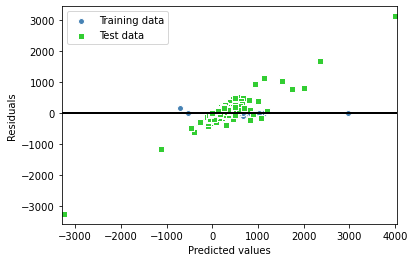

In [114]:
## Train quadratic regression model
from sklearn.preprocessing import PolynomialFeatures
reg = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad_train = quadratic.fit_transform(X_train)
X_quad_test = quadratic.fit_transform(X_test)
reg = reg.fit(X_quad_train, y_train)
y_train_pred = reg.predict(X_quad_train)
y_test_pred = reg.predict(X_quad_test)

print('MSE train: %.2f, test: %.2f' % (
      mean_squared_error(y_train, y_train_pred),
      mean_squared_error(y_test, y_test_pred),))
print('R^2 train: %.4f, test: %.4f' % (
      r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

plt.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
l = min([y_train_pred.min(), y_test_pred.min()]) - 50
u = max([y_train_pred.max(), y_test_pred.max()]) + 50
plt.hlines(y=0, xmin=l, xmax=u, color='black', lw=2)
plt.xlim([l, u])
plt.show()

MSE train: 0.00, test: 59671808.61
R^2 train: 1.0000, test: -5919.7411


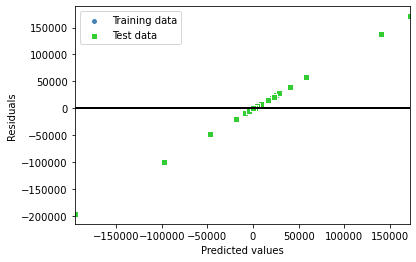

In [115]:
## Train cubic regression model
from sklearn.preprocessing import PolynomialFeatures
reg = LinearRegression()
cubic = PolynomialFeatures(degree=3)
X_cubic_train = cubic.fit_transform(X_train)
X_cubic_test = cubic.fit_transform(X_test)
reg = reg.fit(X_cubic_train, y_train)
y_train_pred = reg.predict(X_cubic_train)
y_test_pred = reg.predict(X_cubic_test)

print('MSE train: %.2f, test: %.2f' % (
      mean_squared_error(y_train, y_train_pred),
      mean_squared_error(y_test, y_test_pred),))
print('R^2 train: %.4f, test: %.4f' % (
      r2_score(y_train, y_train_pred),
      r2_score(y_test, y_test_pred)))

plt.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
l = min([y_train_pred.min(), y_test_pred.min()]) - 50
u = max([y_train_pred.max(), y_test_pred.max()]) + 50
plt.hlines(y=0, xmin=l, xmax=u, color='black', lw=2)
plt.xlim([l, u])
plt.show()